In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import json
sns.set_context("notebook")

In [6]:
def load_sweep(path: str) -> pd.DataFrame:
    with open(path) as f:
        return pd.DataFrame.from_dict(
            dict(**line, **result)
            for line in map(json.loads, f)
            if "results" in line
            for result in line["results"]
        ).drop(columns=["results"])

(pd.concat([load_sweep("data/sweep.jsonl").assign(combine_context_and_prompt=True),
                 load_sweep("data/sweep_original.jsonl").assign(combine_context_and_prompt=False)])
    .reset_index(drop=True)
    .drop(columns=["id", "output"])
    .groupby(["dataset", "shots", "model_scale", "sparsity", "k", "local_ratio", "combine_context_and_prompt"], dropna=False).mean()
    .reset_index()
    .to_json("summary_prefill.json")
)

In [8]:
df = (pd.read_json("summary_prefill.json")
    .pipe(lambda d: d.assign(score=np.where(d.match.isna(), d.rougeL, d.match.astype("float"))))
)

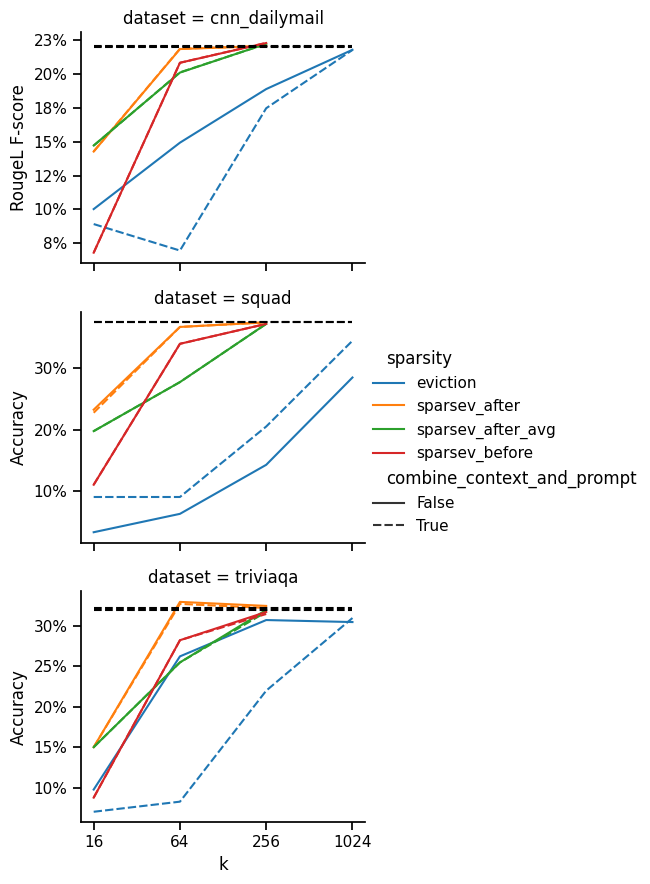

In [9]:
def get_name(s: pd.Series) -> str:
    if str(s.sparsity) == "eviction":
        return f"eviction + local({100*s.local_ratio:.0f}%)"
    return s.sparsity

model_scales = ["1b", "2.8b", "6.9b"]
g = sns.relplot(data=df.pipe(lambda d: d[d.sparsity != "none"]),
                y="score", x="k", hue="sparsity", style="combine_context_and_prompt", row="dataset",
                kind="line", facet_kws=dict(sharey=False), height=3, aspect=1.5)
for (dataset,), d in df.pipe(lambda d: d[d.sparsity == "none"]).groupby(["dataset"]):
    if dataset in g.axes_dict:
        ax = g.axes_dict[dataset]
        ax.hlines(d.score, 16, 1024, "k", linestyle="dashed", label="dense baseline")
        ax.set_xscale("log", base=2)
        ax.set_xticks([16, 64, 256, 1024])
        ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
        ax.set_ylabel("RougeL F-score" if dataset == "cnn_dailymail" else "Accuracy")